In [7]:
import eryn
from numpy import random
import numpy as np
from eryn.prior import ProbDistContainer, uniform_dist
from eryn.ensemble import EnsembleSampler
from eryn.state import State
from chainconsumer import ChainConsumer
import corner
import matplotlib.pyplot as plt
from eryn.moves import GaussianMove

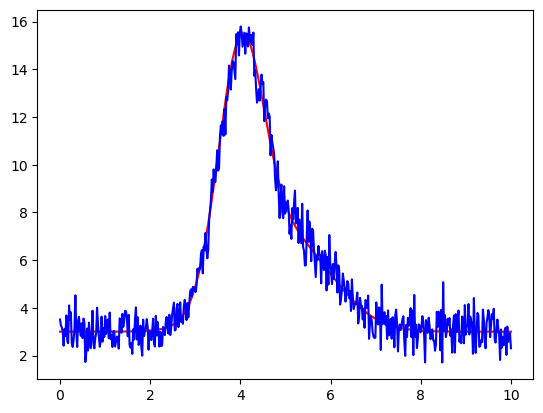

In [8]:

# define gaussian function

def gaussian(t, b, m, s):
    return b*np.exp(-0.5*(t-m)**2/s**2)

# define function to sum the gaussians and add a constant background

def gauss_model(t, a, params):
    function = np.zeros_like(t)
    if params is not None:
        for i in params:
            function = function + gaussian(t, *i)
    if a is not None:
        function = function + a[0][0]
    return function

# generate data with noise variance ns and true parameters pars, a

ns = 0.6
pars = [
    [10, 4, 0.5],
    [4, 5, 1]
]
a = [[3]]

t = np.linspace(0, 10, 500)
signal = gauss_model(t, a, pars)
total = signal + random.normal(0, ns, 500)

# plot true model and data

x = gauss_model(t, a, pars)

plt.plot(t, x, 'r')
plt.plot(t, total, 'b')
plt.show()

In [16]:

# define the log_likelihood function

def log_likelihood(all_params, t, total, ns):
    a, params = all_params
    return -0.5*((total - gauss_model(t, a, params))**2).sum()/ns**2

# branch names and dimensions. Works with nleaves_min=[0,0], doesn't work with nleaves_min=[1,0] .

branch_names = ["constant", "gauss"]

ndim = [1, 3]
nleaves_min = [1, 0]
nleaves_max = [1, 6]
nwalkers = 100
ntemps = 10

# priors and moves

priors = {
    "constant" : {
        0: uniform_dist(0.1, 5)
    },
    "gauss" : {
        0: uniform_dist(1, 20),
        1: uniform_dist(0, 10),
        2: uniform_dist(0.01, 6)
    }
}


cov = {
    "constant" : np.identity(ndim[0])*0.001,
    "gauss" : np.identity(ndim[1])*0.001
}

moves = GaussianMove(cov)

# Ensemble. Setting nleaves_min to default still produces error.

ensemble = EnsembleSampler(
    nwalkers,
    ndim,
    log_likelihood,
    priors,
    args = [t, total, ns],
    tempering_kwargs = dict(ntemps=ntemps),
    nbranches = len(branch_names),
    branch_names = branch_names,
    nleaves_max = nleaves_max,
    nleaves_min = nleaves_min,
    moves = moves,
    rj_moves=True)

# assign coordinates and inds and save state

coords = {
    name : np.zeros((ntemps, nwalkers, leaves, dims)) for name, leaves, dims in zip(branch_names, nleaves_max, ndim)
}

for name, leaves, dims in zip(branch_names, nleaves_max, ndim):
    for d in range(dims):
        coords[name][:, :, :, d] = priors[name][d].rvs(size=(ntemps, nwalkers, leaves))

inds = {
    "constant" : np.ones(shape=(ntemps, nwalkers, nleaves_max[0]), dtype=bool),
    "gauss" : np.random.randint(low=0, high=2, size=(ntemps, nwalkers, nleaves_max[1]), dtype=bool)
}

state = State(coords, inds=inds)

In [ ]:

# run mcmc

nsteps = 5000

out = ensemble.run_mcmc(state, nsteps, burn=1000, progress=True)

In [ ]:

# plot model orders

nleaves_const = ensemble.get_nleaves()['constant']
nleaves_gauss = ensemble.get_nleaves()['gauss']
bns = (
    np.arange(0, nleaves_max[1] + 2) - 0.5
)  # Just to make it pretty and center the bins

fig, ax = plt.subplots(ntemps, 1, sharex=True)
fig.set_size_inches(10, 12)
for temp, ax_t in enumerate(ax):
    ax_t.hist(nleaves_const[:, temp].flatten(), lw=4, bins=bns, color='royalblue', alpha=.8, density=True, label="const, T={}".format(temp))
    ax_t.hist(nleaves_gauss[:, temp].flatten(), lw=4, bins=bns,color='orange', alpha=.8, label="gauss, T={}".format(temp), density=True)
    ax_t.legend(loc="upper right")
ax_t.set_xlabel("Order $k$ of model")